In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
plt.style.use('seaborn')
conn = sqlite3.connect('zippedData/im.db')
import numpy as np
%matplotlib inline

In [2]:
test_sql_df = pd.read_sql("""
SELECT mb.movie_id, mb.primary_title, mb.start_year, mb.runtime_minutes, mb.genres, p.primary_name, 
pr.category, mr.averagerating, mr.numvotes

FROM movie_basics AS mb
JOIN principals AS pr
    USING(movie_id)
JOIN persons AS p
    USING(person_id)
JOIN movie_ratings as mr
    USING(movie_id)
WHERE pr.category IN ('director')
GROUP BY movie_id, person_id
;
""",conn).drop_duplicates(subset = ['movie_id'])

In [3]:
test_sql_df['genres'] = test_sql_df['genres'].str.split(",", expand = True)[0]
test_sql_df = test_sql_df.drop_duplicates(subset = ['primary_title','start_year'])
test_sql_df.duplicated(subset = ['primary_title','start_year']).sum()

0

In [4]:
rtcurrent = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')

In [5]:
rtcurrent = rtcurrent.drop_duplicates(subset = ['movie_title','original_release_date'])
rtcurrent.dropna(subset = ['original_release_date'], inplace = True)
rtcurrent['release_year'] = rtcurrent['original_release_date'].str[-4:].astype(int)

In [6]:
sql_rt_merged = test_sql_df.merge(rtcurrent, left_on = ['primary_title','start_year'], right_on = ['movie_title','release_year'])

In [7]:
sql_rt_merged['original_release_date'] = pd.to_datetime(sql_rt_merged['original_release_date'])

In [8]:
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])

In [9]:
full_merge = sql_rt_merged.merge(tn_movie_budgets, left_on = ['primary_title','original_release_date'] ,  right_on = ['movie','release_date'])
full_merge = full_merge.drop_duplicates(subset = ['primary_title','original_release_date'])

In [10]:
full_merge['worldwide_gross'] = full_merge['worldwide_gross'].str.replace(',','').str.replace('$','').astype(int)
full_merge

,movie_id,primary_title,start_year,runtime_minutes,genres_x,primary_name,category,averagerating,numvotes,movie_title,...,original_release_date,production_company,tomatometer_status,release_year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0365907,A Walk Among the Tombstones,2014,114.0,Action,Scott Frank,director,6.5,105116,A Walk Among the Tombstones,...,2014-09-19,Universal Studios,Fresh,2014,67,2014-09-19,A Walk Among the Tombstones,"$28,000,000","$26,017,685",62108587
1,tt0369610,Jurassic World,2015,124.0,Action,Colin Trevorrow,director,7.0,539338,Jurassic World,...,2015-06-12,Universal Pictures,Fresh,2015,34,2015-06-12,Jurassic World,"$215,000,000","$652,270,625",1648854864
2,tt0376136,The Rum Diary,2011,119.0,Comedy,Bruce Robinson,director,6.2,94787,The Rum Diary,...,2011-10-28,The Film District,Rotten,2011,16,2011-10-28,The Rum Diary,"$45,000,000","$13,109,815",21544732
3,tt0383010,The Three Stooges,2012,92.0,Comedy,Bobby Farrelly,director,5.1,28570,The Three Stooges,...,2012-04-13,20th Century Fox,Rotten,2012,4,2012-04-13,The Three Stooges,"$30,000,000","$44,338,224",54052249
4,tt0398286,Tangled,2010,100.0,Adventure,Byron Howard,director,7.8,366366,Tangled,...,2010-11-24,Walt Disney Pictures,Certified-Fresh,2010,15,2010-11-24,Tangled,"$260,000,000","$200,821,936",586477240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,tt7634968,What Men Want,2019,117.0,Comedy,Adam Shankman,director,4.9,10141,What Men Want,...,2019-02-08,Paramount Pictures,Rotten,2019,21,2019-02-08,What Men Want,"$20,000,000","$54,611,903",69911903
1113,tt7784604,Hereditary,2018,127.0,Drama,Ari Aster,director,7.3,151571,Hereditary,...,2018-06-08,Windy Hill Pictures,Certified-Fresh,2018,56,2018-06-08,Hereditary,"$10,000,000","$44,069,456",70133905
1114,tt8155288,Happy Death Day 2U,2019,100.0,Drama,Christopher Landon,director,6.3,27462,Happy Death Day 2U,...,2019-02-13,Universal Pictures,Fresh,2019,78,2019-02-13,Happy Death Day 2U,"$9,000,000","$28,051,045",64179495
1115,tt8632862,Fahrenheit 11/9,2018,128.0,Documentary,Michael Moore,director,6.7,11628,Fahrenheit 11/9,...,2018-09-21,NaN,Certified-Fresh,2018,29,2018-09-21,Fahrenheit 11/9,"$5,000,000","$6,352,306",6653715


In [11]:
genres_comp = full_merge.groupby(['genres_x'])[['worldwide_gross']].agg('mean').sort_values(by = 'worldwide_gross', ascending = False)
genres_count = full_merge.groupby(['genres_x'])[['worldwide_gross']].agg('count')

display(genres_comp)
display(genres_count)

,worldwide_gross
genres_x,
Family,1.259200e+09
Animation,3.521304e+08
Adventure,3.028423e+08
Action,2.626458e+08
Mystery,2.376665e+08
Romance,1.269313e+08
Horror,9.178227e+07
Biography,7.701366e+07
Drama,7.059574e+07


,worldwide_gross
genres_x,
Action,355
Adventure,135
Animation,6
Biography,80
Comedy,220
Crime,52
Documentary,14
Drama,183
Family,1


<class 'pandas.core.indexes.base.Index'>


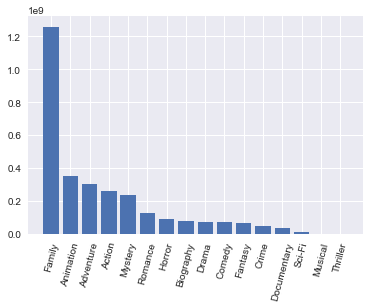

In [12]:
fig, ax = plt.subplots()

bar_x = genres_comp.index
bar_y = genres_comp['worldwide_gross']


print(type(bar_x))
ax.bar(bar_x,bar_y)
ax.tick_params(axis='x', rotation=75)

#ax = genres_comp.plot.bar(y = 'worldwide_gross')

In [13]:
full_merge.loc[full_merge['production_company']=='Netflix']

,movie_id,primary_title,start_year,runtime_minutes,genres_x,primary_name,category,averagerating,numvotes,movie_title,...,original_release_date,production_company,tomatometer_status,release_year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
820,tt2737304,Bird Box,2018,124.0,Drama,Susanne Bier,director,6.6,218063,Bird Box,...,2018-12-13,Netflix,Fresh,2018,17,2018-12-13,Bird Box,"$19,800,000",$0,0


# BUDGET ANALYSIS

In [2]:
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
money_columns = ['production_budget','domestic_gross','worldwide_gross']
tn_movie_budgets[money_columns] = tn_movie_budgets[money_columns].replace([',','\$'], '', regex = True).astype(int)
tn_movie_budgets['profit'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets['ROI'] = tn_movie_budgets['profit'] / tn_movie_budgets['production_budget']
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,-1.000000
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,39.082500
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,-0.732400
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,-1.000000


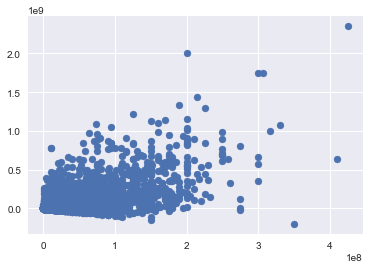

In [3]:
fig, ax = plt.subplots()

budget = tn_movie_budgets['production_budget']
worldwidegross = tn_movie_budgets['worldwide_gross']
domesticgross = tn_movie_budgets['domestic_gross']

profit = worldwidegross - budget

ax.scatter(budget,profit);

In [4]:
tn_movie_budgets.corr()

,id,production_budget,domestic_gross,worldwide_gross,profit,ROI
id,1.000000,-0.035278,0.008255,-0.009422,-0.001172,0.001433
production_budget,-0.035278,1.000000,0.685682,0.748306,0.608752,-0.048715
domestic_gross,0.008255,0.685682,1.000000,0.938853,0.926605,0.062669
worldwide_gross,-0.009422,0.748306,0.938853,1.000000,0.981811,0.047238
profit,-0.001172,0.608752,0.926605,0.981811,1.000000,0.070439
ROI,0.001433,-0.048715,0.062669,0.047238,0.070439,1.000000


In [5]:
bins = [0, 5e7, 1e8, 1.5e8, 2e8, 2.5e8]
labels = ['low', '100mil', '150mil','200mil','250mil']
tn_movie_budgets['budg_cat'] = pd.cut(x = tn_movie_budgets['production_budget'], bins = bins, labels = labels, include_lowest = True)
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI,budg_cat
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577,NaN
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,NaN
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,NaN
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,NaN
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,NaN
...,...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,-1.000000,low
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,39.082500,low
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,-0.732400,low
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,-1.000000,low


In [6]:
print(max(tn_movie_budgets['production_budget']))

425000000


In [7]:
numbins = 10

labels = [ (max(tn_movie_budgets['production_budget']) / numbins) * i for i in np.arange(1,numbins+1)]
print(len(labels))
tn_movie_budgets['budg_cat'], cut_bin = pd.qcut(tn_movie_budgets['production_budget'], q = numbins, labels = labels, retbins = True)


10


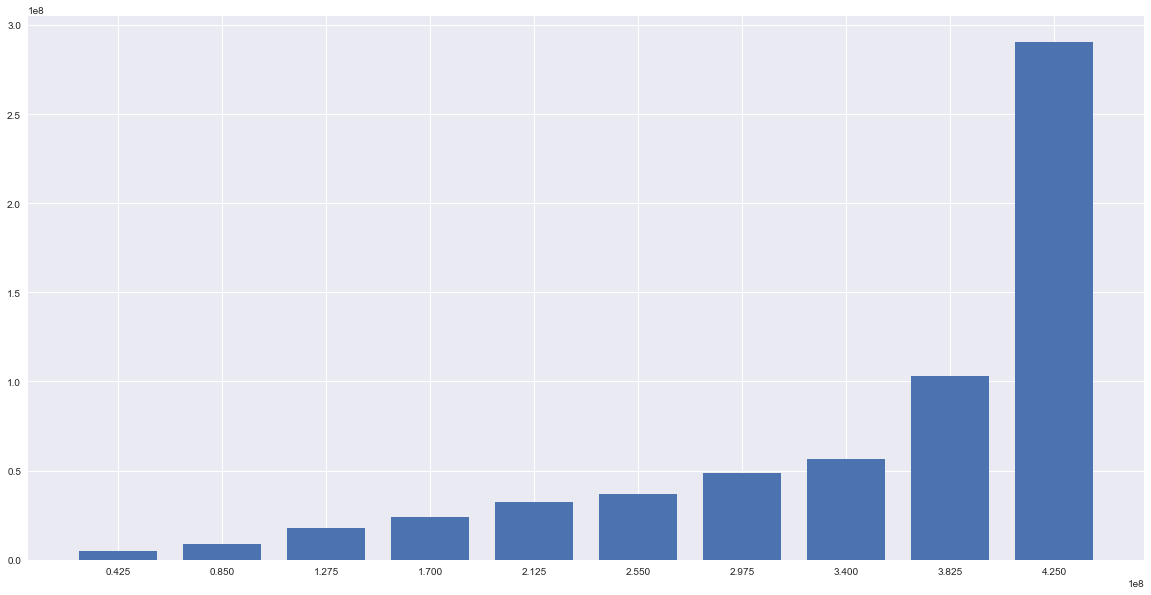

In [8]:
prof_test = tn_movie_budgets.groupby(['budg_cat'])[['profit']].agg('mean')
#display(prof_test)

fig, ax = plt.subplots(figsize = (20,10))

profbar_x = list(prof_test.index)
profbar_y = list(prof_test['profit'])

#print(profbar_x)
ax.bar(profbar_x,profbar_y         , width = .75 * (profbar_x[1]-profbar_x[0]));
#ax.set_ylim(0,1e9)
#ax.set_xlim(0,400000000)
ax.set_xticks(profbar_x);

<BarContainer object of 25 artists>

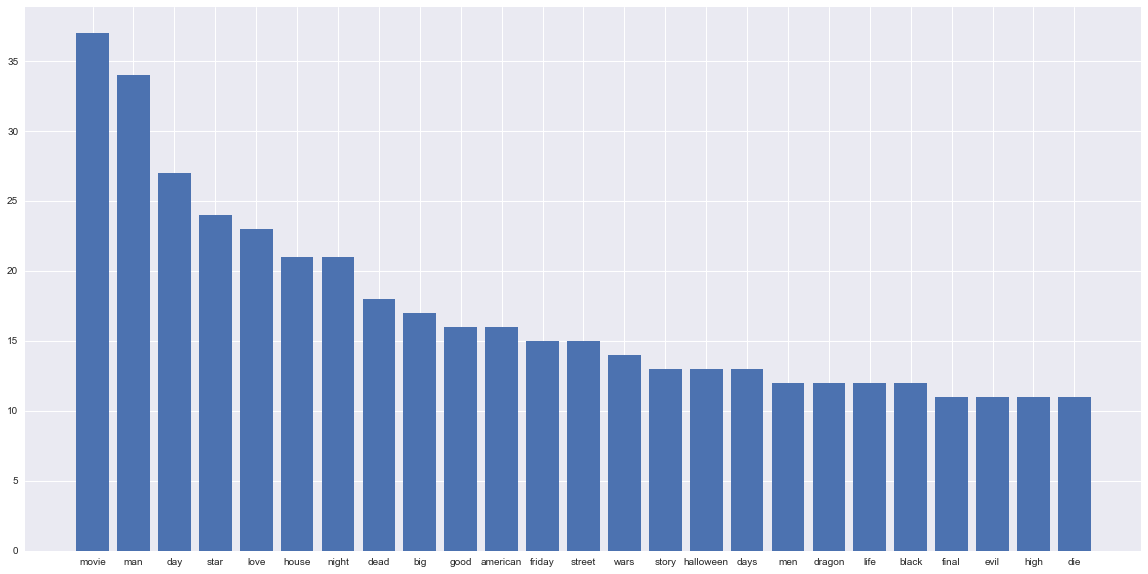

In [26]:
title_vs_gross = tn_movie_budgets.loc[tn_movie_budgets['ROI'] > 1][['movie']]


title_vs_gross['movie'] = title_vs_gross['movie'].str.lower()

title_vs_gross['movie'].replace([':','\.','\,',"'"], '', regex = True)

title_vs_gross['movie'] = title_vs_gross['movie'].replace([':','\.','\,',"'"], '', regex = True)
title_vs_gross
cleaned_titles = title_vs_gross['movie'].str.split(expand=True).stack().value_counts()

cleaned_titles = cleaned_titles.reset_index()

stopwords = ['the','and','of','a','to','in','2','3','on','&','with','ii','for','is','it','harry','from','part',"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]

cleaned_titles = cleaned_titles[~cleaned_titles['index'].isin(stopwords)]

cleaned_titles = cleaned_titles.rename(columns = {0:'count','index':'word'})

cleaned_titles_top = cleaned_titles.head(25)

fig, ax = plt.subplots(figsize= (20,10))




ax.bar( cleaned_titles_top['word'],cleaned_titles_top['count'])
